### **Udacity Data Scientist Nanodegree** - CRISP-DM model
---

# **Business Understanding**

**Airbnb** is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities [[1]](https://en.wikipedia.org/wiki/Airbnb#Overview). Here, millions of hosts and travelers choose to advertise their space and book unique accommodations, anywhere in the world. In addition, Airbnb experience hosts share their passions and interests with travelers and locals alike [[2]](https://www.airbnb.com.br/help/article/2503/o-que-é-o-airbnb-e-como-ele-funciona).


Made available by [Kaggle](https://www.kaggle.com/airbnb/boston), we're going to venture into Boston Airbnb dataset and try to answer the questions that the data points to us.

1. *What time do people usually visit Boston?*
2. *Who are the users who rent on AirBnB?*
3. *Which fields most influence rental prices?*
4. *Bonus: But after all, what do customers have to say?*

**How about you? What motivates you to discover new places?**

# **Data Understanding**

In [1]:
# data preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from calendar import month_abbr

# modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

# sentiment analysis
import nltk
import string
nltk.download('vader_lexicon')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def get_explanatory(df: pd.DataFrame) -> None:
    """
    
    Args:
        - df: pandas DataFrame with data
    
    Return:
        - Exploratory analysis of the data
    """    
    print("[+] numer of rows: ", df.shape[0])
    print("[+] numer of columns: ", df.shape[1])
    print("[+] null percentage:")
    print(df.isnull().mean())
    index_max_missing_values = np.argmax(df.isnull().mean())
    print("[+] max. missing values (column): ", df.isnull().mean().keys()[index_max_missing_values])
    print("[+] columns:")
    print(df.columns)
    print("[+] data types II: ", set(df.dtypes))
    return

## **CALENDAR dataset**
---

In [3]:
calendar = pd.read_csv("boston/calendar.csv")
calendar.head(3)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN


In [4]:
get_explanatory(calendar)

[+] numer of rows:  1308890
[+] numer of columns:  4
[+] null percentage:
listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64
[+] max. missing values (column):  price
[+] columns:
Index(['listing_id', 'date', 'available', 'price'], dtype='object')
[+] data types II:  {dtype('O'), dtype('int64')}


## Overview
  Just over 50% of the prices are <i>NaNs</i>. However, null prices correspond to unavailable flights indicated by the letter <b><i>f</i></b> in the data set.

In [5]:
# currently the price data type is string, so we should make it float

calendar['price'] = calendar.price.replace('[\$,]', '', regex=True).astype(float) # modifying the price data type
calendar.price[calendar.price.notnull()].head(3) # confirming changes

365    65.0
366    65.0
367    65.0
Name: price, dtype: float64

In [6]:
"""
split date into day-month-year columns

checkout pandas DateTimeIndex documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html
"""

calendar_aux = calendar.copy()
calendar_aux['day'] = pd.DatetimeIndex(calendar_aux['date']).day
calendar_aux['month'] = pd.DatetimeIndex(calendar_aux['date']).month
calendar_aux['year'] = pd.DatetimeIndex(calendar_aux['date']).year

In [7]:
"""
translate integer months to string i.e.  01 -> January (Jan)
"""

calendar_aux['month'] = calendar_aux['month'].apply(lambda month: month_abbr[month])
calendar_aux.head()

,listing_id,date,available,price,day,month,year
0,12147973,2017-09-05,f,NaN,5,Sep,2017
1,12147973,2017-09-04,f,NaN,4,Sep,2017
2,12147973,2017-09-03,f,NaN,3,Sep,2017
3,12147973,2017-09-02,f,NaN,2,Sep,2017
4,12147973,2017-09-01,f,NaN,1,Sep,2017


In [8]:
calendar_aux.dropna(subset=['price'], axis=0, inplace=True) # drop rows with NaN prices
print(f"null price percentage: {calendar_aux['price'].isnull().mean()}%    calendar shape: {calendar_aux.shape}")

null price percentage: 0.0%    calendar shape: (643037, 7)


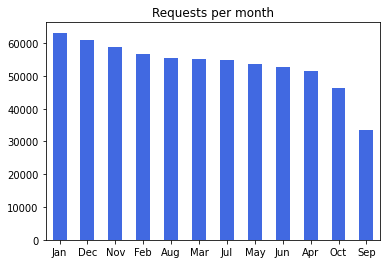

In [9]:
calendar_aux.month.value_counts().plot(kind='bar', rot=0, title="Requests per month", color="royalblue");

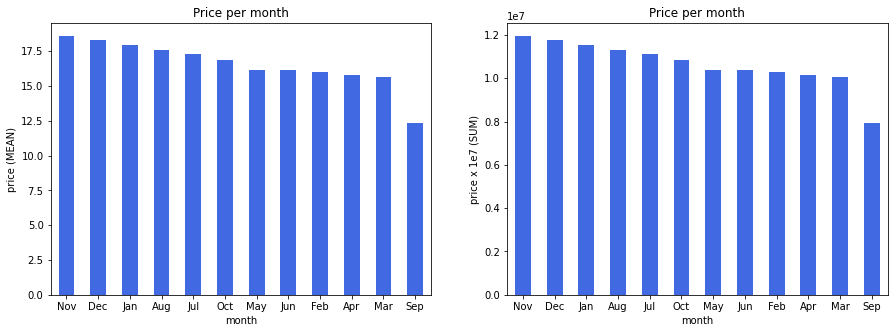

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(121)
(calendar_aux.groupby(['month'])['price'].sum() / (calendar_aux.shape[0] - calendar_aux.price.isnull().sum())).sort_values(ascending=False).plot(kind="bar", ylabel="price (MEAN)", rot=0, title="Price per month", color="royalblue");

plt.subplot(122)
calendar_aux.groupby(['month'])['price'].sum().sort_values(ascending=False).plot(kind="bar", ylabel="price x 1e7 (SUM)", rot=0, title="Price per month", color="royalblue");

#### **Explanation**
---

##### **When do people usually visit Boston?**

   According to the [U.S. News website](https://travel.usnews.com/Boston_MA/When_To_Visit/), the best time to visit Boston is from June to October due to the more pleasant weather provided by autumn. It is, therefore, the most expensive time to visit due to the number of tourists who come to the place for events that take place in that period.



   The data, however, present another perspective. <b>Requests per month</b> shows that the largest number of rents was made in the months of January, December, and November, which were also the most profitable months when analyzing both <b>Price per month</b>. These months, according to the [Santorini Dave website](https://santorinidave.com/best-time-to-visit-boston) has fewer visitors due to cold weather, making prices lower, confirming the peaks on the charts.

In [11]:
calendar_aux.groupby(['month'])['price'].sum().sort_values(ascending=False)

month
Nov    11949813.0
Dec    11748139.0
Jan    11549466.0
Aug    11297226.0
Jul    11129255.0
Oct    10817676.0
May    10382979.0
Jun    10363503.0
Feb    10280396.0
Apr    10135248.0
Mar    10032940.0
Sep     7916920.0
Name: price, dtype: float64

## **LISTINGS dataset**
---

In [12]:
listings = pd.read_csv("boston/listings.csv", parse_dates=['host_since'])
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


In [13]:
get_explanatory(listings)

[+] numer of rows:  3585
[+] numer of columns:  95
[+] null percentage:
id                                  0.000000
listing_url                         0.000000
scrape_id                           0.000000
last_scraped                        0.000000
name                                0.000000
                                      ...   
cancellation_policy                 0.000000
require_guest_profile_picture       0.000000
require_guest_phone_verification    0.000000
calculated_host_listings_count      0.000000
reviews_per_month                   0.210879
Length: 95, dtype: float64
[+] max. missing values (column):  neighbourhood_group_cleansed
[+] columns:
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_

## Overview
  Listings dataset is the core of the analysis. This is where the main fields are, like neighborhoods, review scores, prices and hosts for example. On the other hand, there are still many fields that will be unnecessary for the analysis, for that, we must treat the data.

In [14]:
listings['price'] = listings.price.replace('[\$,]', '', regex=True).astype(float) # modifying the price data type
listings['host_since_year'] = pd.DatetimeIndex(listings['host_since']).year 

In [15]:
# choose the most important columns for this study

important_columns = ['id', 'host_since', 'host_location',
    'host_response_time', 'host_is_superhost', 'host_neighbourhood', 
    'host_has_profile_pic', 'street', 'neighbourhood', 
    'neighbourhood_cleansed', 'city', 'state','country',
    'property_type', 'room_type', 'accommodates', 
    'bathrooms', 'bedrooms', 'beds', 'price',
    'guests_included', 'number_of_reviews',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value']

cleaned_listings = listings[important_columns].copy()
cleaned_listings['host_since'] = listings['host_since_year'].copy() # create a new column with only year of host_sinc. This will facilitate a broader approach.
cleaned_listings.head(3)

,id,host_since,host_location,host_response_time,host_is_superhost,host_neighbourhood,host_has_profile_pic,street,neighbourhood,neighbourhood_cleansed,...,price,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,12147973,2015,"Boston, Massachusetts, United States",NaN,f,Roslindale,t,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,250.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3075044,2012,"Boston, Massachusetts, United States",within an hour,f,Roslindale,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,65.0,0,36,94.0,10.0,9.0,10.0,10.0,9.0,9.0
2,6976,2009,"Boston, Massachusetts, United States",within a few hours,t,Roslindale,t,"Ardale St., Boston, MA 02131, United States",Roslindale,Roslindale,...,65.0,1,41,98.0,10.0,9.0,10.0,10.0,9.0,10.0


In [16]:
get_explanatory(cleaned_listings)

[+] numer of rows:  3585
[+] numer of columns:  29
[+] null percentage:
id                             0.000000
host_since                     0.000000
host_location                  0.003068
host_response_time             0.131381
host_is_superhost              0.000000
host_neighbourhood             0.094561
host_has_profile_pic           0.000000
street                         0.000000
neighbourhood                  0.151464
neighbourhood_cleansed         0.000000
city                           0.000558
state                          0.000000
country                        0.000000
property_type                  0.000837
room_type                      0.000000
accommodates                   0.000000
bathrooms                      0.003905
bedrooms                       0.002789
beds                           0.002510
price                          0.000000
guests_included                0.000000
number_of_reviews              0.000000
review_scores_rating           0.226778
review_s

## Overview
  Listings dataset is the core of the analysis. This is where the main fields are, like neighborhoods, review scores, prices and hosts for example. On the other hand, there are still many fields that will be unnecessary for the analysis, for that, we must treat the data. With the cleaner dataset, we can make better observations. Ratings are the columns that have the most missing data

In [17]:
# better view of review scores
listings.groupby(['host_since_year'])[['review_scores_value', 'review_scores_location', 'review_scores_cleanliness', 'review_scores_communication']].mean().sort_values(ascending=True, by='host_since_year')

,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_communication
host_since_year,,,,
2008,9.000000,9.000000,9.000000,9.666667
2009,8.645161,9.516129,9.086022,9.172043
2010,9.117647,9.129412,9.188235,9.564706
2011,9.140704,9.391960,9.315000,9.595000
2012,9.281746,9.571429,9.357143,9.765873
2013,9.121593,9.438155,9.301887,9.683438
2014,9.227886,9.345345,9.261976,9.672156
2015,9.160458,9.414040,9.226361,9.628940
2016,9.231034,9.465517,9.206186,9.676976


In [18]:
reviews_df = listings[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

reviews_df = reviews_df.apply(lambda col: col.fillna(0.0))
reviews_df['price'] = listings.price
price_mean = reviews_df['price'].mean()

In [19]:
def low_high_price(listings_price: float) -> str:
    '''
    Function that indicates whether the price is above or below average. Results are indicated by chars ('L' or 'H')
    
    Args:
        - listings_price: float -> price to be evaluated 
    
    Return:
        - character indicating whether the price is above (H) or below (L) the mean
    '''
    return 'H' if listings_price < price_mean else 'L'

In [20]:
price_mean = reviews_df['price'].mean() # getting the average price
reviews_df['price'] = reviews_df['price'].apply(low_high_price) # replace the price column with the indicative chars

In [21]:
H = reviews_df[reviews_df['price'] == 'H'].drop('price', axis=1) # just above average prices
L = reviews_df[reviews_df['price'] == 'L'].drop('price', axis=1) # just below average prices

In [22]:
H.head()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
1,10.0,9.0,10.0,10.0,9.0,9.0
2,10.0,9.0,10.0,10.0,9.0,10.0
3,10.0,10.0,10.0,10.0,10.0,10.0
4,10.0,10.0,10.0,10.0,9.0,10.0
5,10.0,10.0,10.0,10.0,9.0,10.0


In [23]:
L.head()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0.0,0.0,0.0,0.0,0.0,0.0
9,10.0,9.0,10.0,10.0,9.0,9.0
24,10.0,10.0,10.0,10.0,10.0,10.0
31,10.0,10.0,10.0,10.0,9.0,10.0
38,10.0,10.0,10.0,10.0,10.0,9.0


In [24]:
# reducing (by mean) to a single column
H = H.apply(lambda col: col.mean(), axis=0)
L = L.apply(lambda col: col.mean(), axis=0)

# calculating the percentage of each one
H_perc = H/H.sum()
L_perc = L/L.sum()

In [25]:
difference_perc_df = pd.concat([H_perc, L_perc], axis=1) # concatenating the averages of the reviews
difference_perc_df.rename(columns={0:'H', 1:'L'}, inplace=True)
difference_perc_df.index = [index.replace('review_scores_', '').capitalize() for index in difference_perc_df.index] # rename indexes

In [26]:
difference_perc_df['Diff_H_L'] = difference_perc_df['H'] - difference_perc_df['L'] # calculating the percentage difference
difference_perc_df.style.bar(subset=['Diff_H_L'], align='mid', color=['#d65f5f', '#5fba7d'])

,H,L,Diff_H_L
Accuracy,0.166846,0.166164,0.000682
Cleanliness,0.162375,0.166033,-0.003659
Checkin,0.171611,0.168920,0.002691
Communication,0.171632,0.169213,0.002419
Location,0.164773,0.168740,-0.003967
Value,0.162764,0.160929,0.001834


---

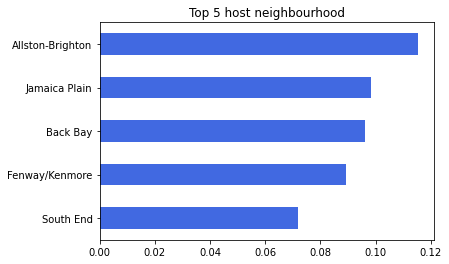

In [27]:
percent_host_neighb = listings.host_neighbourhood.value_counts() / (listings.shape[0] - listings.host_neighbourhood.isnull().sum()) # percentage of each neighborhood
top_5_host_neighb = percent_host_neighb.head().sort_values(ascending=True)
top_5_host_neighb.plot(kind="barh", title="Top 5 host neighbourhood", color="royalblue");

In [28]:
percent_host_neighb.sort_values(ascending=False).head()

Allston-Brighton    0.115527
Jamaica Plain       0.098275
Back Bay            0.096118
Fenway/Kenmore      0.089341
South End           0.071781
Name: host_neighbourhood, dtype: float64

In [29]:
listings.groupby(['host_neighbourhood'])['review_scores_value'].mean().sort_values(ascending=False).head()

host_neighbourhood
Coral Way             10.000000
Bernal Heights        10.000000
Mission District      10.000000
Malden                10.000000
Financial District     9.833333
Name: review_scores_value, dtype: float64

In [30]:
listings.groupby(['host_neighbourhood'])['price'].mean().sort_values(ascending=False).head()

host_neighbourhood
Bernal Heights        375.000000
Sunnyvale             365.000000
Chelsea               340.000000
West End              298.841463
Financial District    298.769231
Name: price, dtype: float64

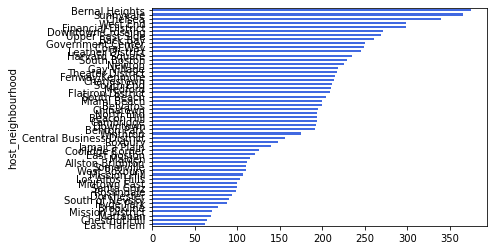

In [31]:
listings.groupby(['host_neighbourhood'])['price'].mean().sort_values(ascending=True).plot(kind='barh', color="royalblue"); # more expensive neighborhoods
# kinda messy, no?

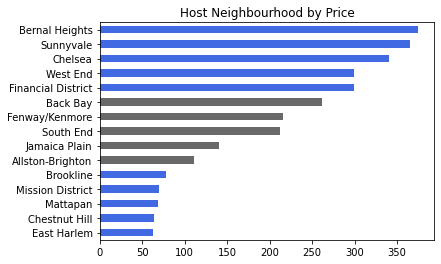

In [32]:
# take only the 5 best and 5 worst and compare with the chosen neighborhoods
prices_per_neighbourhood = listings.groupby(['host_neighbourhood'])['price'].mean().sort_values(ascending=False)
all_together = pd.concat([prices_per_neighbourhood.head(), prices_per_neighbourhood.tail(), prices_per_neighbourhood[top_5_host_neighb.keys()]], axis=0).sort_values(ascending=True)

colors_list = ['dimgray' if name in top_5_host_neighb.keys() else 'royalblue' for name in all_together.keys()]
all_together.sort_values(ascending=True).plot(kind='barh', color=colors_list, title='Host Neighbourhood by Price');

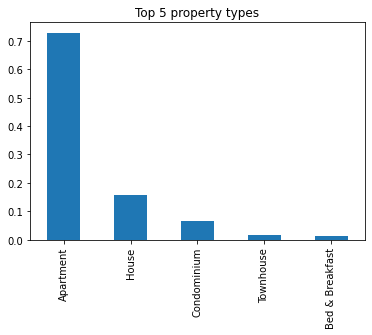

In [33]:
# the types of properties that customers prefer
percent_prop_type = listings.property_type.value_counts() / listings.shape[0]
percent_prop_type.head(5).plot(kind="bar", title="Top 5 property types");

#### **Explanation**
---

##### **Who are the people who rent on AirBnB?**

The search for apartments is also a strong point, with more than 70% of searches, according to <b>Top 5 property types</b>. We can check too the 5 most searched neighborhoods by visitors, which, when compared to <b>Host Neighbourhood by Price</b>, shows that most visitors search average prices.

The table presented gives an overview of the difference in review scores between above and below average neighborhood prices. The biggest differentials of neighborhoods with prices above the average are the <i>cleanliness</i> and <i>location</i>.

In [34]:
listings_score_price = listings.dropna(subset=['review_scores_value'], axis=0)

In [35]:
listings_score_price.groupby(['neighbourhood'])[['review_scores_value','price']].mean().sort_values(by="price", ascending=False).head(10)

,review_scores_value,price
neighbourhood,,
Financial District,10.000000,281.250000
Downtown Crossing,9.047619,273.190476
Cambridge,7.500000,254.500000
Leather District,9.800000,253.400000
Chinatown,9.088889,247.266667
Back Bay,9.127854,238.365297
West End,8.891892,230.567568
Theater District,8.863636,221.863636
Beacon Hill,9.248366,214.856209


## Overview
Through this table, we can answer the question: *"is higher price synonymous with quality?"*. As much as the highest rating mean belongs to the most expensive neighborhood, it is not possible to say with certainty because the rating values ​​do not follow a linear order.

In [36]:
# fill_mean = lambda col: col.fillna(col.mean())
# listings[['review_scores_value', 'price']] = listings[['review_scores_value', 'price']].apply(fill_mean)

## **REVIEWS dataset**
---

In [37]:
reviews = pd.read_csv("boston/reviews.csv", parse_dates=['date'])
reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [38]:
get_explanatory(reviews)

[+] numer of rows:  68275
[+] numer of columns:  6
[+] null percentage:
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000776
dtype: float64
[+] max. missing values (column):  comments
[+] columns:
Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')
[+] data types II:  {dtype('<M8[ns]'), dtype('int64'), dtype('O')}


In [39]:
listings_interest_columns = ['id', 'neighbourhood', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
reviews_interest_columns = ['listing_id', 'comments']

In [40]:
listings_step_x = listings[listings_interest_columns]
listings_step_x.head(3)

,id,neighbourhood,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,12147973,Roslindale,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3075044,Roslindale,65.0,94.0,10.0,9.0,10.0,10.0,9.0,9.0
2,6976,Roslindale,65.0,98.0,10.0,9.0,10.0,10.0,9.0,10.0


In [41]:
get_explanatory(listings_step_x)

[+] numer of rows:  3585
[+] numer of columns:  10
[+] null percentage:
id                             0.000000
neighbourhood                  0.151464
price                          0.000000
review_scores_rating           0.226778
review_scores_accuracy         0.229568
review_scores_cleanliness      0.228173
review_scores_checkin          0.228731
review_scores_communication    0.228173
review_scores_location         0.229289
review_scores_value            0.229010
dtype: float64
[+] max. missing values (column):  review_scores_accuracy
[+] columns:
Index(['id', 'neighbourhood', 'price', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'],
      dtype='object')
[+] data types II:  {dtype('O'), dtype('int64'), dtype('float64')}


In [42]:
reviews_step_x = reviews[reviews_interest_columns]
reviews_step_x.columns = ['id', 'comments']
reviews_step_x

,id,comments
0,1178162,My stay at islam's place was really cool! Good...
1,1178162,Great location for both airport and city - gre...
2,1178162,We really enjoyed our stay at Islams house. Fr...
3,1178162,The room was nice and clean and so were the co...
4,1178162,Great location. Just 5 mins walk from the Airp...
...,...,...
68270,7462268,Joe y su mujer son encantadores. La habitación...
68271,7462268,Joe was on his way to Jamaica to be married! o...
68272,7462268,The room was very clean as were the bathrooms ...
68273,7462268,Staying in Lower Allston at Joe and Nancy's pl...


In [43]:
listings_reviews = listings_step_x.merge(reviews_step_x, on="id", how="right")
listings_reviews

,id,neighbourhood,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments
0,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,My stay at islam's place was really cool! Good...
1,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,Great location for both airport and city - gre...
2,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,We really enjoyed our stay at Islams house. Fr...
3,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,The room was nice and clean and so were the co...
4,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,Great location. Just 5 mins walk from the Airp...
...,...,...,...,...,...,...,...,...,...,...,...
68270,7462268,NaN,75.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,Joe y su mujer son encantadores. La habitación...
68271,7462268,NaN,75.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,Joe was on his way to Jamaica to be married! o...
68272,7462268,NaN,75.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,The room was very clean as were the bathrooms ...
68273,7462268,NaN,75.0,97.0,10.0,10.0,10.0,10.0,9.0,10.0,Staying in Lower Allston at Joe and Nancy's pl...


In [44]:
numeric_columns_listings = listings_reviews.select_dtypes(include=['float', 'int']).columns
listings_reviews[numeric_columns_listings] = listings_reviews[numeric_columns_listings].apply(lambda col: col.fillna(col.mean()), axis=1)

In [45]:
listings_reviews.dropna(subset=['neighbourhood'], axis=0, inplace=True)

In [46]:
get_explanatory(listings_reviews)

[+] numer of rows:  60771
[+] numer of columns:  11
[+] null percentage:
id                             0.000000
neighbourhood                  0.000000
price                          0.000000
review_scores_rating           0.000000
review_scores_accuracy         0.000000
review_scores_cleanliness      0.000000
review_scores_checkin          0.000000
review_scores_communication    0.000000
review_scores_location         0.000000
review_scores_value            0.000000
comments                       0.000675
dtype: float64
[+] max. missing values (column):  comments
[+] columns:
Index(['id', 'neighbourhood', 'price', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'comments'],
      dtype='object')
[+] data types II:  {dtype('O'), dtype('int64'), dtype('float64')}


In [47]:
pd.DataFrame(listings_reviews.query("review_scores_rating >= 70.0"))['neighbourhood'].value_counts().sum()

60545

In [48]:
# reviews greater than 70.0
reviews_gt_70 = pd.DataFrame(listings_reviews.query("review_scores_rating >= 70.0"))['neighbourhood'].value_counts()
reviews_gt_70.head()

Jamaica Plain       8641
Dorchester          6410
South End           5141
Allston-Brighton    5106
East Boston         4622
Name: neighbourhood, dtype: int64

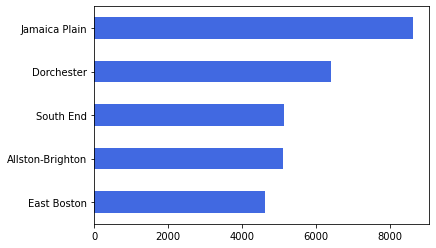

In [49]:
pd.DataFrame(listings_reviews.query("review_scores_rating >= 70.0"))['neighbourhood'].value_counts().head().sort_values(ascending=True).plot(kind="barh", color="royalblue");

In [50]:
pd.DataFrame(listings_reviews.query("review_scores_rating < 70.0"))['neighbourhood'].value_counts().sum()

226

In [51]:
# reviews lower than 70.0
reviews_lt_70 = pd.DataFrame(listings_reviews.query("review_scores_rating < 70.0"))['neighbourhood'].value_counts()
reviews_lt_70.head()

Dorchester          52
Allston-Brighton    50
Mission Hill        33
Fenway/Kenmore      14
East Boston         14
Name: neighbourhood, dtype: int64

In [52]:
reviews_overview = pd.concat([reviews_gt_70, reviews_lt_70], axis=1).dropna()
reviews_overview.columns = ["Greater Than 70", "Lower Than 70"]
reviews_overview.sort_values(by=['Greater Than 70', 'Lower Than 70'], ascending=False)

,Greater Than 70,Lower Than 70
Jamaica Plain,8641,3.0
Dorchester,6410,52.0
South End,5141,9.0
Allston-Brighton,5106,50.0
East Boston,4622,14.0
Back Bay,4367,11.0
South Boston,4251,2.0
North End,4094,5.0
Beacon Hill,3480,14.0
Roxbury,3234,2.0


In [53]:
listings_reviews.groupby(['neighbourhood'])['review_scores_rating'].mean().sort_values(ascending=False).head()

neighbourhood
Financial District    100.392857
Brookline             100.000000
Leather District       98.188679
Charlestown            95.507903
Roslindale             95.478528
Name: review_scores_rating, dtype: float64

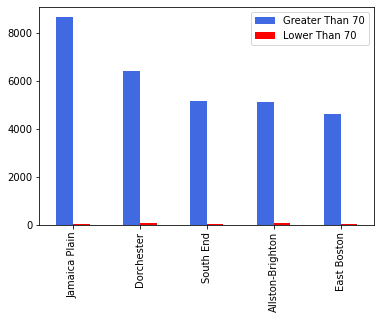

In [54]:
# relationship between higher and lower than average ratings
reviews_overview.head().plot(kind="bar", color=["royalblue", "red"]);

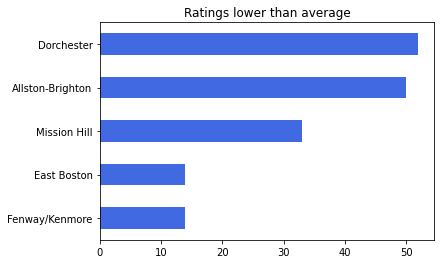

In [55]:
# neighborhoods with average ratings lower than 7.0
listings_reviews[listings_reviews.review_scores_rating < 70.0]['neighbourhood'].value_counts().head(5).sort_values(ascending=True).plot(kind="barh", color="royalblue", title="Ratings lower than average");

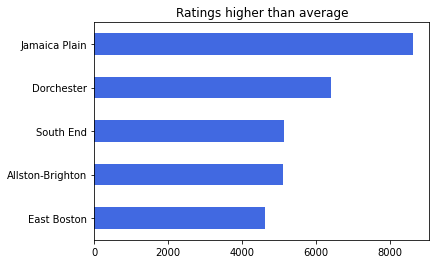

In [56]:
# neighborhoods with average ratings greater than or equal 7.0
listings_reviews[listings_reviews.review_scores_rating >= 70.0]['neighbourhood'].value_counts().head(5).sort_values(ascending=True).plot(kind="barh", color="royalblue", title="Ratings higher than average");

# **Modeling**

In [57]:
def char_to_boolean(row: str) -> bool:
    '''
    change string fields to booleans
    
    Args:
        - row: str -> column rows to be analyzed
        
    Returns:
        - True or False according to row value ('t': True, 'f': False)
    
    '''
    return True if row == 't' else False

In [58]:
important_columns = ['neighbourhood', 'property_type',
    'room_type', 'accommodates', 'bathrooms', 'host_since',
    'bedrooms', 'beds', 'price', 'guests_included']

cleaned_listings = listings[important_columns].copy() # choosing only the fields considered main to predict the price
cleaned_listings['host_since'] = pd.DatetimeIndex(cleaned_listings['host_since']).year

In [59]:
list(cleaned_listings.columns)

['neighbourhood',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'host_since',
 'bedrooms',
 'beds',
 'price',
 'guests_included']

In [60]:
# exploring numerical data
df_numerical_columns = cleaned_listings.select_dtypes(include=['int', 'float']).columns
cleaned_listings[df_numerical_columns].isnull().mean()

bathrooms    0.003905
bedrooms     0.002789
beds         0.002510
price        0.000000
dtype: float64

In [61]:
# imputating mean on numerical values
fill_mean = lambda col: col.fillna(col.mean())
cleaned_listings[df_numerical_columns] = cleaned_listings[df_numerical_columns].apply(fill_mean, axis=0)

In [62]:
cleaned_listings[df_numerical_columns].isnull().mean()

bathrooms    0.0
bedrooms     0.0
beds         0.0
price        0.0
dtype: float64

In [63]:
# exploring categorical data
df_categorical_columns = cleaned_listings.select_dtypes(include=['object']).columns
# dummy variables
for variable in df_categorical_columns:
    cleaned_listings = pd.concat([cleaned_listings.drop(variable, axis=1), pd.get_dummies(cleaned_listings[variable], prefix=variable, prefix_sep='_', dummy_na=True, drop_first=True)], axis=1)

In [64]:
X = cleaned_listings.drop(['price'], axis=1)
y = cleaned_listings['price']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2513) # split data in train & test. The random_state was choosen by test

In [66]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape # checking the shapes - how many data goes to learning

((2509, 52), (2509,), (1076, 52), (1076,))

In [67]:
lm_model = LinearRegression(normalize=True) # instantiate the Linear Regression model
lm_model.fit(X_train, y_train) #fit the model on train data

LinearRegression(normalize=True)

In [68]:
# predict the model for test and train
y_test_preds = lm_model.predict(X_test) 
y_train_preds = lm_model.predict(X_train) 

# calculate the r-squared & mean_squared_error
rsquared_score_test = r2_score(y_test, y_test_preds)
rsquared_score_train = r2_score(y_train, y_train_preds)
ms_error = mean_squared_error(y_test, y_test_preds) # calculate mean squared error
length_y_test = len(y_test)
length_y_train = len(y_train)

print('mean squared error: %.2f' % ms_error)
print("r-squared score for test model was {} on {} values.".format(rsquared_score_test, length_y_test))
print("r-squared score for train model was {} on {} values.".format(rsquared_score_train, length_y_train))

mean squared error: 5108.26
r-squared score for test model was 0.5669556105555928 on 1076 values.
r-squared score for train model was 0.2905793764881407 on 2509 values.


In [69]:
# instatiating PCA to change the shape of the X_test to fit the scatter plot
pca = PCA(n_components=1)
x_test = pca.fit_transform(X_test)

In [70]:
x_test.shape, y_test.shape

((1076, 1), (1076,))

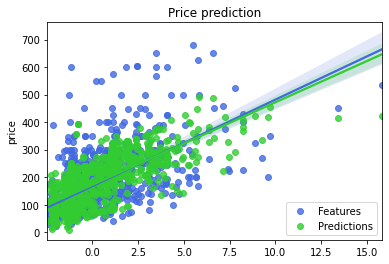

In [71]:
# visualize the data 

sns.regplot(x=x_test, y=y_test, color='royalblue', label='Features')
sns.regplot(x=x_test, y=y_test_preds, color='limegreen', label='Predictions')

plt.title("Price prediction")
plt.legend(loc='lower right')
plt.show()

In [72]:
# based on Udacity lessons
def coef_weights(coefficients, X_train):
    '''
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    
    Args:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    
    Returns:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [73]:
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head()

,est_int,coefs,abs_coefs
20,neighbourhood_Harvard Square,-177.490863,177.490863
15,neighbourhood_Downtown Crossing,114.157138,114.157138
18,neighbourhood_Financial District,111.947424,111.947424
17,neighbourhood_Fenway/Kenmore,100.678897,100.678897
6,neighbourhood_Back Bay,93.764680,93.764680


In [74]:
coef_df.head(10).style.bar(subset=['abs_coefs'], align='mid')

,est_int,coefs,abs_coefs
20,neighbourhood_Harvard Square,-177.490863,177.490863
15,neighbourhood_Downtown Crossing,114.157138,114.157138
18,neighbourhood_Financial District,111.947424,111.947424
17,neighbourhood_Fenway/Kenmore,100.678897,100.678897
6,neighbourhood_Back Bay,93.764680,93.764680
23,neighbourhood_Leather District,93.036452,93.036452
32,neighbourhood_Theater District,82.770913,82.770913
7,neighbourhood_Beacon Hill,79.942061,79.942061
30,neighbourhood_South Boston,79.156056,79.156056
45,property_type_Other,79.002505,79.002505


In [75]:
coef_df.est_int.str.split('_').apply(lambda label: label[0]).value_counts() # just collecting the field names and verifying thier frequency

neighbourhood    30
property         13
room              3
bathrooms         1
accommodates      1
bedrooms          1
beds              1
host              1
guests            1
Name: est_int, dtype: int64

<AxesSubplot:ylabel='est_int'>

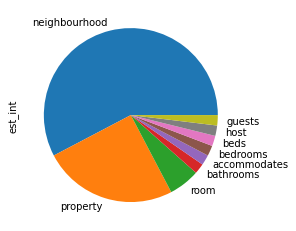

In [76]:
coef_df.est_int.str.split('_').apply(lambda label: label[0]).value_counts().plot(kind="pie")

#### **Explanation**
---

##### **Which fields most influence rental prices?**

Would you be able to predict the price of accommodation based only on the *neighborhood*, *type of property*, *type of room*, *number of rooms*, *bathrooms* and *beds*, and how long the host is on business? And what influence do these fields have on price? 30% of the values ​​were separated for tests and the **Price prediction** regression graph shows the comparison of the actual values ​​with the prediction. The values ​​do not fully match, but the trend lines slope closely together, supporting a prediction closer to the true value. From the table presented, we can also see that the *neighborhood* is the field that most influences the price, followed by the type of *property* and *room*.

In [77]:
listings_reviews.head()

,id,neighbourhood,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,comments
0,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,My stay at islam's place was really cool! Good...
1,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,Great location for both airport and city - gre...
2,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,We really enjoyed our stay at Islams house. Fr...
3,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,The room was nice and clean and so were the co...
4,1178162,East Boston,95.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,Great location. Just 5 mins walk from the Airp...


In [78]:
listings_reviews.isnull().mean()

id                             0.000000
neighbourhood                  0.000000
price                          0.000000
review_scores_rating           0.000000
review_scores_accuracy         0.000000
review_scores_cleanliness      0.000000
review_scores_checkin          0.000000
review_scores_communication    0.000000
review_scores_location         0.000000
review_scores_value            0.000000
comments                       0.000675
dtype: float64

In [79]:
listings_reviews['comments'].fillna('', inplace=True) # replace NaN values to use NLTK to predict the sentiment analysis

In [80]:
listings_reviews.isnull().mean()

id                             0.0
neighbourhood                  0.0
price                          0.0
review_scores_rating           0.0
review_scores_accuracy         0.0
review_scores_cleanliness      0.0
review_scores_checkin          0.0
review_scores_communication    0.0
review_scores_location         0.0
review_scores_value            0.0
comments                       0.0
dtype: float64

In [81]:
def get_sentiment_score(comment: str):
    '''
    Function returns the percentage of feeling (negative, neutral and positive) of a comment based on the SentimentIntensityAnalyzer from the NLTK library
    
    Args:
        - comment: str -> comments to be analyzed
    
    Returns: the percentage of feeling (negative, neutral and positive) in a dictionary or N/A for null comments
    '''
    if comment != '':
        s_analyser = SentimentIntensityAnalyzer()
        return s_analyser.polarity_scores(comment)
    else:
        return 'N/A'

In [82]:
def get_reviews(comments: list, review_type: str) -> list:
    '''
    For each element in the processed list of words, separate those that have a positive or negative content, based on the function argument.
    
    Args:
        - comments: list -> list of words
        - review_type -> kind of feeling desired ('pos': positive comments, 'neg': negative comments)
    
    Returns: list with only comments with review_type category
    '''
    values = []
    s_analyser = SentimentIntensityAnalyzer()
    for word in comments:
        result = s_analyser.polarity_scores(word)
        if result[review_type] > 0.4:
            values.append(word)

    return values

In [83]:
# based on https://youtu.be/Ns2Adgcd3yE
def process_data(text: str) -> list:
    '''
    clears unnecessary elements for evaluating the sentiment percentage in the text, such as punctuation and stopwords
    
    Args:
        - text: str -> text to be analysed
    
    Returns: list of all lowercase and processed words
    '''
    no_punctuation = [letter for letter in text if letter not in string.punctuation] # eliminate punctuation
    no_punctuation = ''.join(no_punctuation) # turn into single string again without punctuation
    
    return [word.lower() for word in no_punctuation.split() if word.lower() not in stopwords.words("english")]

In [84]:
# listings_reviews['clean_text'] = listings_reviews['comments'].apply(process_data)
# listings_reviews['positive'] = listings_reviews['clean_text'].apply(lambda row: get_reviews(row, 'pos'))
# listings_reviews['negative'] = listings_reviews['clean_text'].apply(lambda row: get_reviews(row, 'neg'))

# the above procedure may take some time to process. If you want to avoid this, use the dataset below (data already processed)
listings_reviews = pd.read_csv("listings_reviews.csv", usecols=["positive", "negative"])
# lambda function: https://stackoverflow.com/questions/32742976/how-to-read-a-column-of-csv-as-dtype-list-using-pandas
correct_formatting = lambda label: label.strip("[]").replace("'","").split(", ") # string -> list
listings_reviews['positive'] = listings_reviews['positive'].apply(correct_formatting)
listings_reviews['negative'] = listings_reviews['negative'].apply(correct_formatting)

In [85]:
listings_reviews[['positive', 'negative']]

,positive,negative
0,"[cool, good, nice, clean, pretty, well]",[]
1,"[great, great, helpful]",[]
2,"[enjoyed, inviting, nice, prepared, share, fin...",[problem]
3,"[nice, clean, safe, helpful, recommend]",[]
4,"[great, good, clean]",[]
...,...,...
60766,"[perfect, easy, excellently, recommended]",[]
60767,"[great, recommend, perfect]",[]
60768,"[enjoyed, great, easy, reach, pleasant, beauti...",[]
60769,"[jewel, hope, easy, fantastic, enjoy, definite...",[]


In [86]:
positives = []
for el in listings_reviews['positive']:
    positives.extend(el)
    
negatives = []
for el in listings_reviews['negative']:
    negatives.extend(el)

In [87]:
frequency_positives = FreqDist(positives) # frequency of each positive word
frequency_negatives = FreqDist(negatives) # frequency of each negative word

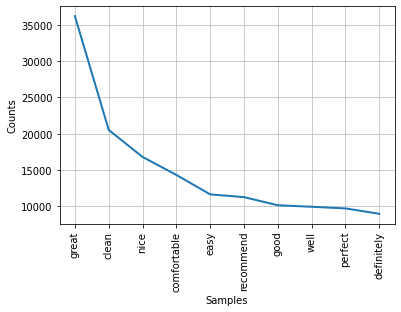

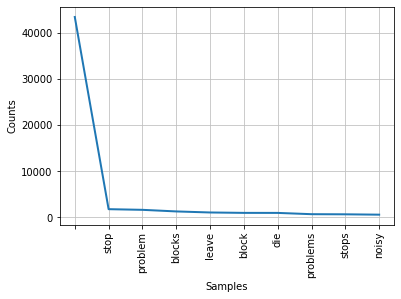

In [88]:
plt.figure(1)
frequency_positives.plot(10, cumulative=False); # show the 10 positive fields that appeared the most in the comments

plt.figure(2)
frequency_negatives.plot(10, cumulative=False); # show the 10 negative fields that appeared the most in the comments

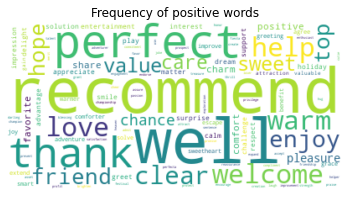

In [89]:
# present the positive words in a different perspective (in WordCloud)
wc_positive = WordCloud(background_color="white").generate(' '.join(frequency_positives))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Frequency of positive words")
plt.axis("off")
plt.show()

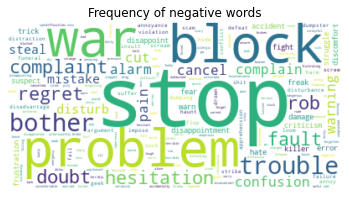

In [90]:
# present the negative words in a different perspective (in WordCloud)
wc_negative = WordCloud(background_color="white").generate(' '.join(frequency_negatives))
plt.imshow(wc_negative, interpolation='bilinear')
plt.title("Frequency of negative words")
plt.axis("off")
plt.show()

##### **Bonus: but after all, what do customers have to say?**

The analysis through customer ratings was not very effective as the comments sometimes did not correspond with the review scores given. That's why it was necessary to comb through each comment and evaluate the positive and negative feelings they expressed. Fortunately the positive results corresponded to most of the comments made and words like *'perfect'*, *'warm'*, *'clear'*, *'care'* and *'love'*, for example, can be seen in the figure **Frequency of positive words**, but it hasn' t all been good. In **Frequency of negative words** we can observe words like *'problem'*, *'bother'*, *'trouble'*, or even worse like *'rob'*, *'cut'* and *'pain'*. So find out more about where you will be staying to avoid frustrating experiences.